Matrix shape: (1000, 489)

Recommendations for Customer: Amanda Anderson
1: Similar Customer → James King (Similarity Score: 0.6218)
2: Similar Customer → Joseph Williams (Similarity Score: 0.4703)
3: Similar Customer → Angela Johnson (Similarity Score: 0.4587)
4: Similar Customer → Mark Anderson (Similarity Score: 0.4506)
5: Similar Customer → David Green (Similarity Score: 0.4479)

Top Product Recommendations:
Product
['Ice Cream']    19
['Banana']       19
['Yogurt']       14
['Tissues']      13
['Cereal']       13
dtype: object


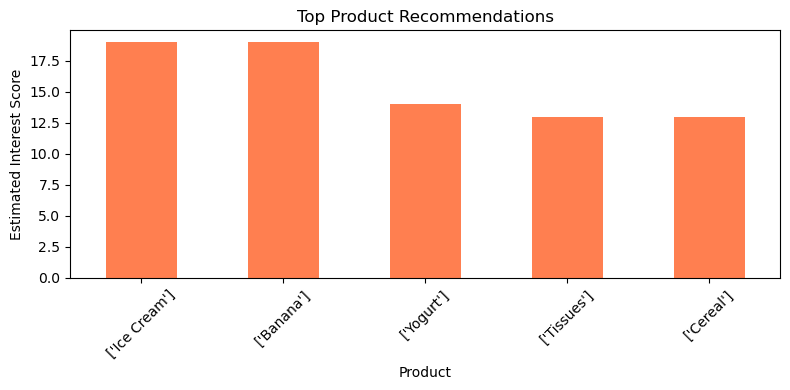

In [ ]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt 
 
# Step 1: Load dataset
df = pd.read_csv("Retail_Transactions_Dataset.csv")  # Replace with your file path

# Step 2: Basic cleaning
df = df.dropna(subset=['Customer_Name', 'Product'])  # Remove missing values
df = df[df['Total_Items'] > 0]                        # Keep only valid purchases
df['Customer_Name'] = df['Customer_Name'].astype(str).str.slice(0, 50)
df['Product'] = df['Product'].astype(str).str.slice(0, 50)

# Step 3: Optional — Limit users and products for performance
top_customers = df['Customer_Name'].value_counts().head(1000).index
top_products = df['Product'].value_counts().head(500).index
df = df[df['Customer_Name'].isin(top_customers) & df['Product'].isin(top_products)]

# Step 4: Create user-item matrix
user_item_matrix = df.pivot_table(index='Customer_Name',
                                  columns='Product',
                                  values='Total_Items',
                                  aggfunc='sum',
                                  fill_value=0)

print("Matrix shape:", user_item_matrix.shape)

# Step 5: Convert to sparse matrix
sparse_matrix = csr_matrix(user_item_matrix.values)

# Step 6: Train KNN model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(sparse_matrix)

# Step 7: Choose a query user (by matrix index)
query_index = 5  # You can change this index
distances, indices = model_knn.kneighbors(sparse_matrix[query_index], n_neighbors=6)

print(f"\nRecommendations for Customer: {user_item_matrix.index[query_index]}")
for i in range(1, len(distances.flatten())):
    print(f"{i}: Similar Customer → {user_item_matrix.index[indices.flatten()[i]]} (Similarity Score: {1 - distances.flatten()[i]:.4f})")

# Step 8: Recommend products based on similar users
query_user_products = user_item_matrix.iloc[query_index]
already_purchased = query_user_products[query_user_products > 0].index.tolist()

recommended_products = pd.Series()
similar_users = indices.flatten()[1:]

for user in similar_users:
    user_vector = user_item_matrix.iloc[user]
    recommended_products = recommended_products.add(user_vector, fill_value=0)

# Remove already purchased
recommended_products = recommended_products.drop(labels=already_purchased, errors='ignore')
top_recommendations = recommended_products.sort_values(ascending=False).head(5)

print("\nTop Product Recommendations:")
print(top_recommendations)

# Step 9: Optional - Visualize the recommendations
plt.figure(figsize=(8, 4))
top_recommendations.plot(kind='bar', color='coral')
plt.title("Top Product Recommendations")
plt.xlabel("Product")
plt.ylabel("Estimated Interest Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()